## 0. Import Libraries

In [1]:
import xarray as xr
import numpy as np

## 1. Resampling Task

In [2]:
path_general = r'/mnt/d/JupyterLab/Yuksek_Lisans/msc_thesis_data'

### 1.1 Open Data

In [3]:
# change these
season = 'SON'
resample_time = 3
step_hour = 1

#### 1.1.1 Model

In [4]:
dt_model = xr.open_dataset(fr'{path_general}/cosmo/Tr011_MPI_RF_PR_{season}_1hr_198501_200512.nc',
                     chunks={"time": 10})

In [5]:
dt_model

<xarray.Dataset>
Dimensions:   (time: 45864, rlat: 107, rlon: 175)
Coordinates:
  * time      (time) datetime64[ns] 1985-09-01 ... 2005-11-30T23:00:00
    lon       (rlat, rlon) float32 dask.array<chunksize=(107, 175), meta=np.ndarray>
    lat       (rlat, rlon) float32 dask.array<chunksize=(107, 175), meta=np.ndarray>
  * rlon      (rlon) float32 -8.3 -8.19 -8.08 -7.97 ... 10.51 10.62 10.73 10.84
  * rlat      (rlat) float32 -6.2 -6.09 -5.98 -5.87 ... 5.13 5.24 5.35 5.46
Data variables:
    TOT_PREC  (time, rlat, rlon) float32 dask.array<chunksize=(10, 107, 175), meta=np.ndarray>
Attributes: (12/13)
    CDI:                       Climate Data Interface version 1.9.10 (https:/...
    Conventions:               CF-1.4
    source:                    /home/yunal/cclm-sp-v3.1.1/src/cclm/cclm.exe}
    title:                     CCLM_v5.0_clm15 Simulation (0.11 Deg) with Med...
    experiment_id:             Tr0.11_RF
    realization:               1
    ...                        ...
    contact:                   Cemre Yuruk Sonuc (yurukc@itu.edu.tr)
    references:                http://www.clm-community.eu/
    creation_date:             2020-03-01 04:03:14
    nco_openmp_thread_number:  1
    history:                   Thu Dec 01 14:24:36 2022: cdo -select,season=S...
    CDO:                       Climate Data Operators version 1.9.10 (https:/...

#### 1.1.2 ERA5

In [6]:
dt_era5 = xr.open_dataset(fr'{path_general}/era5/era5_TOT_PREC_{season}_1hr_1985_2005.nc',
                     chunks={"time": 10})

In [7]:
dt_era5

<xarray.Dataset>
Dimensions:    (longitude: 93, latitude: 41, time: 45864)
Coordinates:
  * longitude  (longitude) float32 24.0 24.25 24.5 24.75 ... 46.5 46.75 47.0
  * latitude   (latitude) float32 44.0 43.75 43.5 43.25 ... 34.5 34.25 34.0
  * time       (time) datetime64[ns] 1985-09-01 ... 2005-11-30T23:00:00
Data variables:
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(10, 41, 93), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-12-08 11:09:37 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### 1.2 Resample

not: buradaki shift time'i = resample(time) / step hour 

In [8]:
def resample_data(data, resample_time, step_hour):
    
    # resample_time: 3 hourly resample is expected
    # step_hour: 1 hourly data

    # calculate resampled data
    shift_time = int(resample_time / step_hour)
    resampled = data.shift(time=shift_time) \
                  .dropna(dim='time',
                          how='all') \
                  .resample(time=fr'{resample_time}H',
                            closed='right').sum()
    
    return resampled

#### 1.2.1 Model

In [9]:
resample_xhr_model = resample_data(dt_model, resample_time, step_hour)
resample_xhr_model = resample_xhr_model.dropna(dim='time')

In [10]:
resample_xhr_model

<xarray.Dataset>
Dimensions:   (time: 15308, rlat: 107, rlon: 175)
Coordinates:
  * time      (time) datetime64[ns] 1985-09-01 ... 2005-11-30T21:00:00
    lon       (rlat, rlon) float32 dask.array<chunksize=(107, 175), meta=np.ndarray>
    lat       (rlat, rlon) float32 dask.array<chunksize=(107, 175), meta=np.ndarray>
  * rlon      (rlon) float32 -8.3 -8.19 -8.08 -7.97 ... 10.51 10.62 10.73 10.84
  * rlat      (rlat) float32 -6.2 -6.09 -5.98 -5.87 ... 5.13 5.24 5.35 5.46
Data variables:
    TOT_PREC  (time, rlat, rlon) float32 dask.array<chunksize=(1, 107, 175), meta=np.ndarray>

In [11]:
resample_xhr_model.to_netcdf(fr'{path_general}/cosmo/Tr011_MPI_RF_PR_{season}_{resample_time}hrsum_198501_200512.nc',)

#### 1.2.2 ERA5

In [12]:
resample_xhr_era5 = resample_data(dt_era5, resample_time, step_hour)
resample_xhr_era5 = resample_xhr_era5.dropna(dim='time')

In [13]:
resample_xhr_era5

<xarray.Dataset>
Dimensions:    (time: 15308, longitude: 93, latitude: 41)
Coordinates:
  * time       (time) datetime64[ns] 1985-09-01 ... 2005-11-30T21:00:00
  * longitude  (longitude) float32 24.0 24.25 24.5 24.75 ... 46.5 46.75 47.0
  * latitude   (latitude) float32 44.0 43.75 43.5 43.25 ... 34.5 34.25 34.0
Data variables:
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(1, 41, 93), meta=np.ndarray>

In [14]:
resample_xhr_era5.to_netcdf(fr'{path_general}/era5/era5_TOT_PREC_{season}_{resample_time}hrsum_1985_2005.nc')

## 2. Check Resampling Details (For cross-checking purposes)

In [1]:
import visjobs

In [56]:
from visjobs.datas import get_MODEL
data = get_MODEL.pick_data(hour='00',latest=True,
                          model='GFS', hourly=False,
                          resolution = 0.25)['dpt2m'].isel(time=slice(0, 18),lon=0,lat=0)-273.15

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/xarray/coding/times.py:119: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


Addressing Data:  http://nomads.ncep.noaa.gov:80/dods/gfs_0p25/gfs20221201/gfs_0p25_00z
Connected GFS Data via OpenDAP


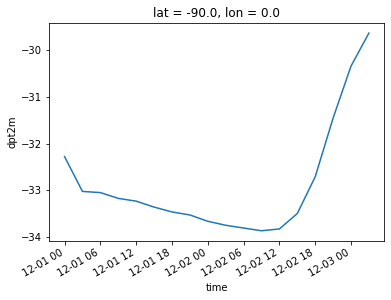

In [57]:
data.plot()

In [70]:
data

<xarray.DataArray 'dpt2m' (time: 18)>
array([-32.274628, -33.02069 , -33.045883, -33.16957 , -33.229156,
       -33.35611 , -33.460236, -33.524643, -33.660294, -33.745667,
       -33.804962, -33.863327, -33.824387, -33.494125, -32.706955,
       -31.449997, -30.33664 , -29.628754], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01 ... 2022-12-03T03:00:00
    lat      float64 -90.0
    lon      float64 0.0

In [59]:
data.shift(time=3)

<xarray.DataArray 'dpt2m' (time: 18)>
array([       nan,        nan,        nan, -32.274628, -33.02069 ,
       -33.045883, -33.16957 , -33.229156, -33.35611 , -33.460236,
       -33.524643, -33.660294, -33.745667, -33.804962, -33.863327,
       -33.824387, -33.494125, -32.706955], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01 ... 2022-12-03T03:00:00
    lat      float64 -90.0
    lon      float64 0.0

In [60]:
# not: buradaki shift time'i = resample(time) / step hour 
# in this case shift = 9 / 3 = 3
data.shift(time=3).dropna(dim='time',how='all').resample(time='9H', closed='right').sum()#.values

<xarray.DataArray 'dpt2m' (time: 6)>
array([ -32.274628,  -99.236145, -100.0455  , -100.9306  , -101.492676,
        -66.20108 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01 ... 2022-12-02T21:00:00
    lat      float64 -90.0
    lon      float64 0.0

In [41]:
data.resample(time='6H', closed='right').sum()#.values

<xarray.DataArray 'dpt2m' (time: 5)>
array([-32.274628, -66.066574, -66.39873 , -66.816345, -67.18494 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-11-30T18:00:00 ... 2022-12-01T18:00:00
    lat      float64 -90.0
    lon      float64 0.0

In [27]:
-33.02069 + -33.045883

-66.066573

In [30]:
-33.16957 + -33.229156

-66.39872600000001

note: closed=right works for us you can use

In [33]:
data.shift(time=-1).dropna(dim='time',how='all').resample(time='6H').sum()

<xarray.DataArray 'dpt2m' (time: 4)>
array([-66.066574, -66.39873 , -66.816345, -67.18494 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01 ... 2022-12-01T18:00:00
    lat      float64 -90.0
    lon      float64 0.0